# 06. Pytorch Transfer Learning

### Why use transfer learning?
There are two main benefits to using transfer learning:

1. Can leverage an existing model (usually a neural network architecture) proven to work on problems similar to our own.
2. Can leverage a working model which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

### Where to find pretrained models

|Location	|What's there?	|Link(s)|
|-|-|-|
|PyTorch domain libraries	|Each of the PyTorch domain libraries (torchvision, torchtext) come with pretrained models of some form. The models there work right within PyTorch.	|[torchvision.models](https://docs.pytorch.org/vision/stable/models.html), [torchtext.models](https://docs.pytorch.org/text/main/models.html), [torchaudio.models](https://docs.pytorch.org/audio/stable/models.html), [torchrec.models]()|
|HuggingFace Hub	|A series of pretrained models on many different domains (vision, text, audio and more) from organizations around the world. There's plenty of different datasets too.	|https://huggingface.co/models, https://huggingface.co/datasets|
|timm (PyTorch Image Models) library	|Almost all of the latest and greatest computer vision models in PyTorch code as well as plenty of other helpful computer vision features.	|https://github.com/rwightman/pytorch-image-models|
|Paperswithcode	|A collection of the latest state-of-the-art machine learning papers with code implementations attached. You can also find benchmarks here of model performance on different tasks.	|https://paperswithcode.com/|

In [47]:
import torch

device = "mps" if torch.mps.is_available() else "cpu"
device

'mps'

## 1. Get Data

In [2]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [3]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and Dataloaders

### 2.1 Creating a transform for `torchvision.models`(manual creation)

When using a pretrained model, it's important that your custom data going into the model is prepared in the same way as the original training data that went into the model.

|Transform number	|Transform required	|Code to perform transform|
|-|-|-|
|1	|Mini-batches of size [batch_size, 3, height, width] where height and width are at least 224x224^.	|torchvision.transforms.Resize() to resize images into [3, 224, 224]^ and torch.utils.data.DataLoader() to create batches of images.|
|2	|Values between 0 & 1.	|torchvision.transforms.ToTensor()|
|3	|A mean of [0.485, 0.456, 0.406] (values across each colour channel).	|torchvision.transforms.Normalize(mean=...) to adjust the mean of our images.|
|4	|A standard deviation of [0.229, 0.224, 0.225] (values across each colour channel).	|torchvision.transforms.Normalize(std=...) to adjust the standard deviation of our images.|


In [7]:
from torchvision import transforms
from going_modular.data_setup import create_dataloaders
# Create a transforms pipline manually
manual_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],# 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225])# 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [29]:
# Creating training and testing Dataloaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=32,
    transform=manual_transform
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x16f85fc20>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models`(auto creation)

In [13]:
# Get a set of pretrained model weights
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
type(weights)

<enum 'EfficientNet_B0_Weights'>

In [16]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [30]:
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=32,
    transform=auto_transforms
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x16f85ecf0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model
The whole idea of transfer learning is to take an already well-performing model on a problem-space similar to yours and then customise it to your use case.

Since we're working on a computer vision problem (image classification with FoodVision Mini), we can find pretrained classification models in torchvision.models.

Exploring the documentation, you'll find plenty of common computer vision architecture backbones such as:

|Architecuture backbone	|Code|
|-|-|
|ResNet's	|torchvision.models.resnet18(), torchvision.models.resnet50()...|
|VGG (similar to what we used for TinyVGG)	|torchvision.models.vgg16()|
|EfficientNet's	|torchvision.models.efficientnet_b0(), torchvision.models.efficientnet_b1()...|
|VisionTransformer (ViT's)	|torchvision.models.vit_b_16(), torchvision.models.vit_b_32()...|
|ConvNeXt	|torchvision.models.convnext_tiny(), torchvision.models.convnext_small()...|
|More available in torchvision.models	|torchvision.models...|


## 3.1 Which pretrained models should you use
It depends on your problem/the device you're working with.

Generally, the higher number in the model name (e.g. efficientnet_b0() -> efficientnet_b1() -> efficientnet_b7()) means better performance but a larger model.

## 3.2 Setting up a pretrained model

In [ ]:
# Set up the model with pretrained weights and send it to the target device
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights).to(device)
model


In [37]:
# 创建一个输入并转到 MPS 上
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# 推理
with torch.no_grad():
    output = model(dummy_input)

output

tensor([[-4.0142e-01, -2.7049e-01, -1.8169e-01, -9.1089e-02, -4.1683e-01,
         -9.2158e-02, -5.8120e-01,  2.1602e-01,  1.9637e-01, -2.3319e-01,
          2.5996e-01,  3.2703e-01,  3.2237e-01,  6.2968e-02,  1.1857e-01,
          2.7203e-01,  4.8125e-01,  3.2804e-01,  3.0782e-01,  2.5202e-02,
         -1.4762e-01, -2.8051e-01, -1.6130e-02, -3.1716e-02, -2.9849e-01,
         -1.1890e-01,  1.4737e-01,  3.8786e-01, -8.0007e-02, -1.8771e-01,
         -2.2876e-01,  1.9319e-01, -9.1704e-02, -5.8276e-01, -1.1079e-01,
         -3.0792e-01, -2.9768e-01, -4.4329e-02,  7.4361e-02, -1.5596e-01,
         -1.4325e-01,  1.1554e-01, -1.2911e-01,  2.1534e-01,  3.3266e-01,
          1.8519e-01, -4.6095e-02, -5.1391e-02, -4.3654e-01, -2.9541e-01,
         -2.9416e-01,  1.7494e-01,  2.2086e-01,  4.2721e-02, -3.2376e-01,
         -3.2731e-01, -8.4742e-02, -3.8270e-02,  4.3632e-01,  1.3950e-02,
          4.1975e-01, -2.0616e-01,  1.1769e-01, -2.4116e-01, -2.5436e-01,
         -7.6171e-02,  1.8026e-02, -1.

Lots and lots and lots of layers.

This is one of the benefits of transfer learning, taking an existing model, that's been crafted by some of the best engineers in the world and applying to your own problem.

Our efficientnet_b0 comes in three main parts:

1. features - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as features or feature extractor, "the base layers of the model learn the different features of images").

2. avgpool - Takes the average of the output of the features layer(s) and turns it into a feature vector.

3. classifier - Turns the feature vector into a vector with the same dimensionality as the number of required output classes (since efficientnet_b0 is pretrained on ImageNet and because ImageNet has 1000 classes, out_features=1000 is the default).

### 3.3 Getting a summary of our momdel with`torchino.summary()`

To learn more about our model, let's use torchinfo's summary() method.

To do so, we'll pass in:

* `model` - the model we'd like to get a summary of.
* `input_size` - the shape of the data we'd like to pass to our model, for the case of `efficientnet_b0`, the input size is `(batch_size, 3, 224, 224)`, though other variants of `efficientnet_bX` have different input sizes.
    * Note: Many modern models can handle input images of varying sizes thanks to `torch.nn.AdaptiveAvgPool2d()`, this layer adaptively adjusts the output_size of a given input as required. You can try this out by passing different size input images to `summary()` or your models.
* `col_names` - the various information columns we'd like to see about our model.
* `col_width` - how wide the columns should be for the summary.
* `row_settings` - what features to show in a row.

In [22]:
# print a summary using torchinf
from torchinfo import summary

summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 3.4 Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the features section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

We can freeze all of the layers/parameters in the features section by setting the attribute requires_grad=False.

For parameters with requires_grad=False, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with requires_grad=False is "untrainable" or "frozen" in place.

In [23]:
# Freeze all base layers in the "features" sections of the model by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False


In [50]:
# Set the manual seeds
torch.manual_seed(42)
torch.mps.manual_seed(42)

# Get the length of class_names
output_shape = len(class_names)
print(f"Model device: {next(model.parameters()).device}")
# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
).to(device=device)
print(f"Model device: {next(model.parameters()).device}")
model = model.to(device)
print(f"Model device: {next(model.parameters()).device}")

Model device: mps:0
Model device: mps:0
Model device: mps:0


In [43]:
# Do a summary after freezing the features and changing the output classifier layer
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

Let's go through them:

* Trainable column - You'll see that many of the base layers (the ones in the features portion) have their Trainable value as False. This is because we set their attribute requires_grad=False. Unless we change this, these layers won't be updated during future training.

* Output shape of classifier - The classifier portion of the model now has an Output Shape value of [32, 3] instead of [32, 1000]. It's Trainable value is also True. This means its parameters will be updated during training. In essence, we're using the features portion to feed our classifier portion a base representation of an image and then our classifier layer is going to learn how to base representation aligns with our problem.

* Less trainable parameters - Previously there were 5,288,548 trainable parameters. But since we froze many of the layers of the model and only left the classifier as trainable, there's now only 3,843 trainable parameters (even less than our TinyVGG model). Though there's also 4,007,548 non-trainable parameters, these will create a base representation of our input images to feed into our classifier layer.

## 4. train model

In [44]:
from torch import nn
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model.parameters(), lr=0.001
)

In [59]:
from going_modular.engine import train
# set the random seeds
torch.manual_seed(42)
torch.mps.manual_seed(42)

# start the timer
from timeit import default_timer as timer
start_time = timer()
print(f"Model device: {next(model.parameters()).device}")
# Set up training and save the results
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)
# end the timer
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} s.")

Model device: mps:0


 20%|██        | 1/5 [00:02<00:08,  2.10s/it]

Epoch: 1 | train_loss: 0.0152 | train_acc: 1.0000 | test_loss: 0.1983 | test_acc: 0.9271


 40%|████      | 2/5 [00:04<00:06,  2.04s/it]

Epoch: 2 | train_loss: 0.0133 | train_acc: 1.0000 | test_loss: 0.1663 | test_acc: 0.9688


 60%|██████    | 3/5 [00:06<00:04,  2.02s/it]

Epoch: 3 | train_loss: 0.0096 | train_acc: 1.0000 | test_loss: 0.1716 | test_acc: 0.9688


 80%|████████  | 4/5 [00:08<00:02,  2.01s/it]

Epoch: 4 | train_loss: 0.0214 | train_acc: 1.0000 | test_loss: 0.1752 | test_acc: 0.9583


100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

Epoch: 5 | train_loss: 0.0068 | train_acc: 1.0000 | test_loss: 0.1409 | test_acc: 0.9688
[INFO] Total training time: 10.074 s.


## 5. Evaluate model by plotting loss curves

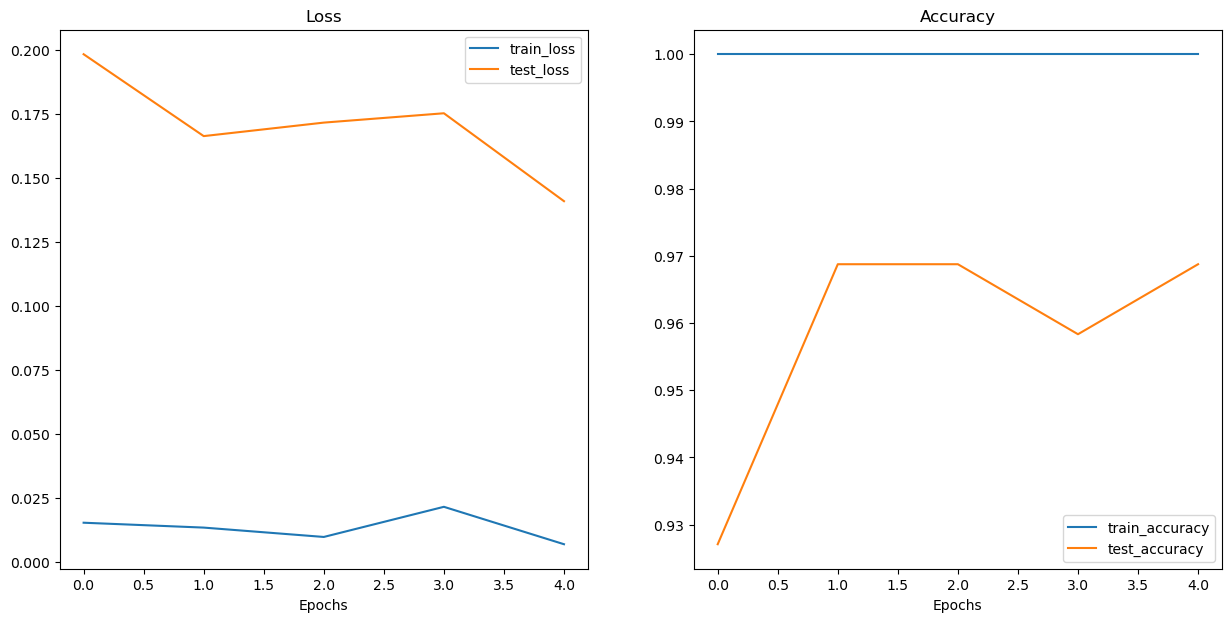

In [60]:
# plot the loss curves of our model 
from helper_functions import plot_loss_curves
plot_loss_curves(results)

## 6. Make predictions on images from the test set

In [71]:
from typing import List, Tuple
from PIL import Image
import matplotlib.pyplot as plt

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    img = Image.open(image_path)
    if img.mode == "RGBA":
        img = img.convert("RGB")

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    
    model.to(device=device)

    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)

        target_image_pred = model(transformed_image.to(device))
    
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred:{class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

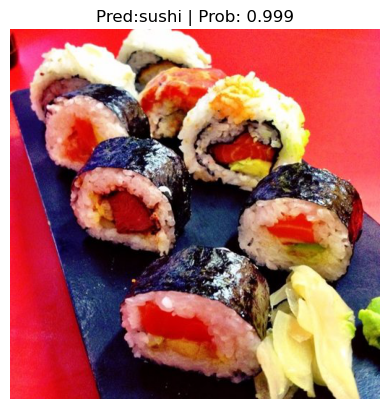

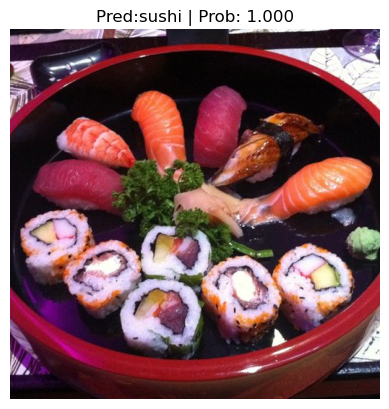

In [72]:
# Get a random list of image paths from test set
import random
num_image_to_plot = 2
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_image_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

### 6.1 Making predictions on a custom image

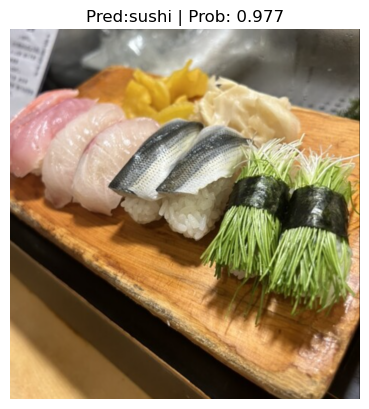

In [73]:
custom_image_path = data_path / "custom-image-sushi.jpeg"

pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)